<a href="https://colab.research.google.com/github/Camilossa/Proyectos-data/blob/main/viviendas_cali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se busca predecir el precio de las casas de acuerdo a sus características en la ciudad de Cali-Colombia

#**Importamos librerías**

In [ ]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Se utiliza pandas profiling para genera informes desde un DataFrame de pandas, lo que nos ayuda a hacer una parte importante del EDA, tal como vizualizar la distribución de cada variable, las correlaciones que tienen entre si, en caso de que haya multicolinealidad nos advierte...

In [ ]:
# Procesamiento Datos
import pandas as pd
#from pandas_profiling import ProfileReport
import numpy as np

# Modelamiento
from scipy.stats import stats,kstest,normaltest,anderson
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#Imputacion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Normalización
from sklearn.preprocessing import StandardScaler

# Visualisación
import matplotlib.pyplot as plt
import seaborn as sns

#**Cargamos los datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Mineria Datos/EXP_MINERIA.csv')
df.head()

id        zona  piso  estrato  preciom  areaconst  parquea  banios  \
0  1.0    Zona Sur   2.0      6.0    880.0      237.0      2.0     5.0   
1  2.0  Zona Oeste   2.0      4.0   1200.0      800.0      3.0     6.0   
2  3.0    Zona Sur   3.0      5.0    250.0       86.0      NaN     2.0   
3  4.0    Zona Sur   NaN      6.0   1280.0      346.0      4.0     6.0   
4  5.0    Zona Sur   2.0      6.0   1300.0      600.0      4.0     7.0   

   habitac         tipo         barrio  longitud  latitud  
0      4.0         Casa          PANCE -76.46300  3.43000  
1      7.0         Casa     MIRAFLORES -76.46400  3.42800  
2      3.0  Apartamento    MULTICENTRO -76.46400  3.42900  
3      5.0  Apartamento  CIUDAD JARDIN -76.46400  3.43300  
4      5.0         Casa          PANCE -76.46438  3.43463

#**Análisis explotario de datos**

Contamos con 8322 muestras y 13 características

In [ ]:
df.shape

(8322, 13)

La mayoría de nuestras variables son cuantitativas continuas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8322 entries, 0 to 8321
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8319 non-null   float64
 1   zona       8319 non-null   object 
 2   piso       5684 non-null   float64
 3   estrato    8319 non-null   float64
 4   preciom    8320 non-null   float64
 5   areaconst  8319 non-null   float64
 6   parquea    6717 non-null   float64
 7   banios     8319 non-null   float64
 8   habitac    8319 non-null   float64
 9   tipo       8319 non-null   object 
 10  barrio     8319 non-null   object 
 11  longitud   8319 non-null   float64
 12  latitud    8319 non-null   float64
dtypes: float64(10), object(3)
memory usage: 845.3+ KB


En las variables piso y parquea tenemos una gran cantidad de nulos, por lo que lo revisaremos más a fondo adelante para aplicar técnicas de imputación de datos.

También debemos validar porqué el resto siguen un patron de 3 valores faltantes, podemos ir suponiendo que estos son datos faltantes no aleatorios.

In [ ]:
df.isnull().sum()

id              3
zona            3
piso         2638
estrato         3
preciom         2
areaconst       3
parquea      1605
banios          3
habitac         3
tipo            3
barrio          3
longitud        3
latitud         3
dtype: int64

Se puede observar que preciom y areaconst tienen una gran desviación estándar, por lo que habrán valores atípicos, y que se vizualizarán mejor en la siguiente parte

In [ ]:
df.describe()

id         piso      estrato      preciom    areaconst  \
count  8319.000000  5684.000000  8319.000000  8320.000000  8319.000000   
mean   4160.000000     3.770936     4.633610   433.891947   174.934938   
std    2401.632778     2.614802     1.029222   328.647244   142.964126   
min       1.000000     1.000000     3.000000    58.000000    30.000000   
25%    2080.500000     2.000000     4.000000   220.000000    80.000000   
50%    4160.000000     3.000000     5.000000   330.000000   123.000000   
75%    6239.500000     5.000000     5.000000   540.000000   229.000000   
max    8319.000000    12.000000     6.000000  1999.000000  1745.000000   

           parquea       banios      habitac     longitud      latitud  
count  6717.000000  8319.000000  8319.000000  8319.000000  8319.000000  
mean      1.835194     3.111311     3.605361   -76.528606     3.417644  
std       1.124909     1.428210     1.459537     0.017398     0.042638  
min       1.000000     0.000000     0.000000   -76.589150     3.333000  
25%       1.000000     2.000000     3.000000   -76.541580     3.380795  
50%       2.000000     3.000000     3.000000   -76.530000     3.416000  
75%       2.000000     4.000000     4.000000   -76.518890     3.452000  
max      10.000000    10.000000    10.000000   -76.463000     3.497700

In [ ]:
df_graficos = df.drop(['id','longitud','latitud'], axis=1)
df_graficos.head()

zona  piso  estrato  preciom  areaconst  parquea  banios  habitac  \
0    Zona Sur   2.0      6.0    880.0      237.0      2.0     5.0      4.0   
1  Zona Oeste   2.0      4.0   1200.0      800.0      3.0     6.0      7.0   
2    Zona Sur   3.0      5.0    250.0       86.0      NaN     2.0      3.0   
3    Zona Sur   NaN      6.0   1280.0      346.0      4.0     6.0      5.0   
4    Zona Sur   2.0      6.0   1300.0      600.0      4.0     7.0      5.0   

          tipo         barrio  
0         Casa          PANCE  
1         Casa     MIRAFLORES  
2  Apartamento    MULTICENTRO  
3  Apartamento  CIUDAD JARDIN  
4         Casa          PANCE

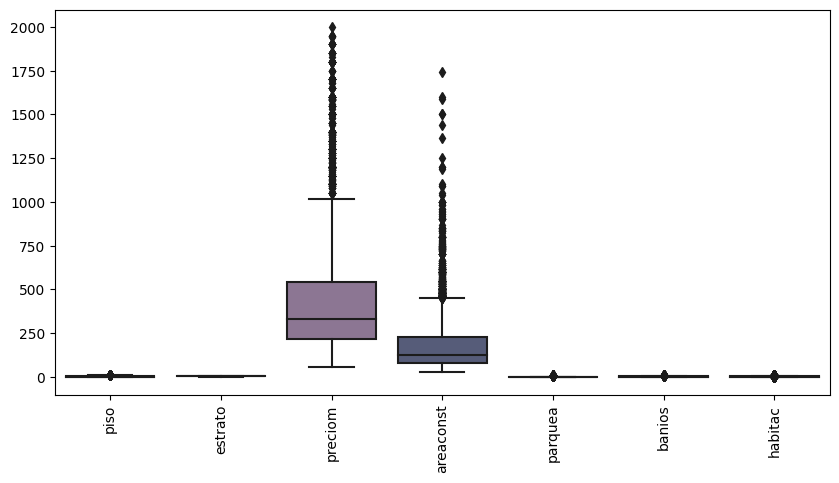

In [ ]:
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
plt.figure(figsize=(10,5))
sns.boxplot(data = df_graficos,palette = shades)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':False}})

Se revisa el reporte generado por pandas profiling y concluimos:

- Sólo contamos con estratos socioeconómicos del 3 al 6.
- La variable tipo tiene un problema de calidad de datos que solucionaremos más adelante.
- En la variable barrio teniamos 460 diferentes barrios, pero gracias a un trabajo de limpieza de datos directamente desde la fuente (csv) pudimos reducir este a 374.
- En términos de relaciones, podemos decír que el precio tiene una relación positiva con el num de habitaciones, parqueaderos, baños y el area.
- Podemos ver nuevamente los valores faltantes de piso y de parquea, pero de manera gráfica.
- Finalmente nos dice que hay una fila duplicada donde todos los valores son Nan, incluendo el id, es decir que si podemos estár hablando de datos faltantes no aleatorios.
- A nivel de gráficas se puede observar que todas tienen una asimetria son positivas, es decir que se prensentan sesgos a la izquierda.

In [ ]:
#profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#profile.to_file(output_file="REPORTE.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#**Transformación de datos**

Iniciamos viendo cómo están las distribuciones de donde están nuestros valores faltantes que son parquea y piso, para a el momento de implementar la imputación ver que no hayan cambiado las distribuciones

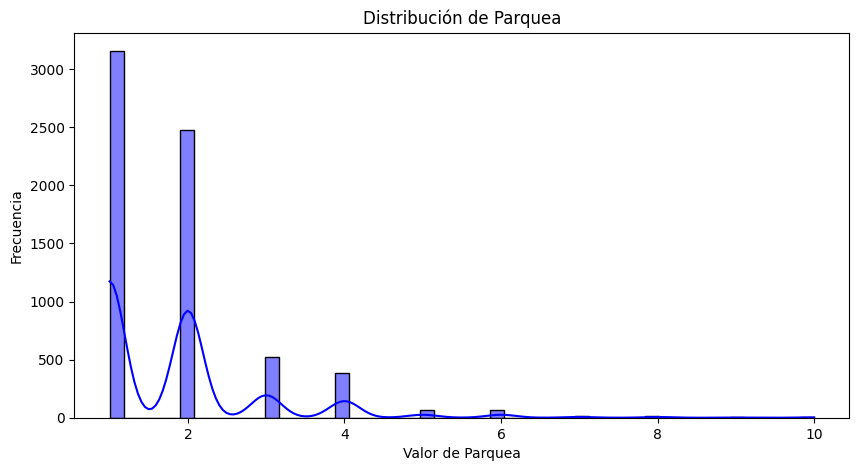

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["parquea"], kde=True, color="blue", bins=50)
plt.title("Distribución de Parquea")
plt.xlabel("Valor de Parquea")
plt.ylabel("Frecuencia")
plt.show()

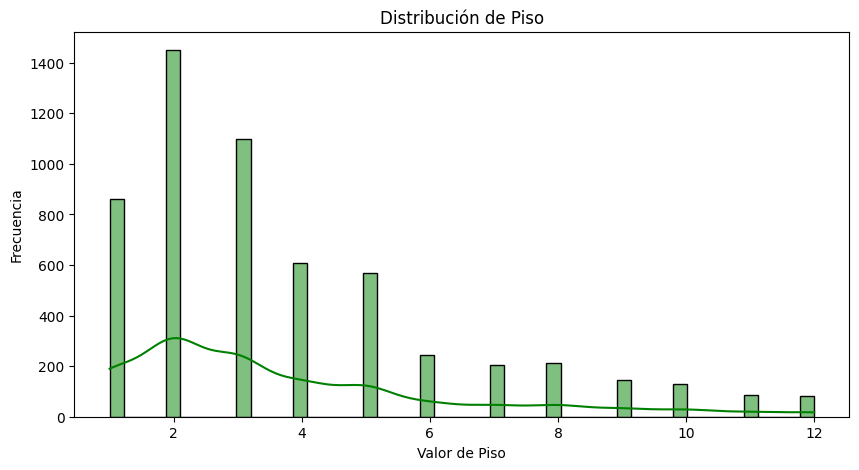

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["piso"], kde=True, color="green", bins=50)
plt.title("Distribución de Piso")
plt.xlabel("Valor de Piso")
plt.ylabel("Frecuencia")
plt.show()

Convertimos los flotantes en enteros, porque esto nos puede afectar la imputación, ya que el numero de baños, parqueaderos, estrato... no puede ser por ejemplo 1.2.

In [ ]:
df["piso"] = df["piso"].astype("Int64")
df["parquea"] = df["parquea"].astype("Int64")
df["banios"] = df["banios"].astype("Int64")
df["habitac"] = df["habitac"].astype("Int64")
df["estrato"] = df["estrato"].astype("Int64")

Validamos que si hayan quedado en enteros

In [ ]:
df.head()

id        zona  piso  estrato  preciom  areaconst  parquea  banios  \
0  1.0    Zona Sur     2        6    880.0      237.0        2       5   
1  2.0  Zona Oeste     2        4   1200.0      800.0        3       6   
2  3.0    Zona Sur     3        5    250.0       86.0     <NA>       2   
3  4.0    Zona Sur  <NA>        6   1280.0      346.0        4       6   
4  5.0    Zona Sur     2        6   1300.0      600.0        4       7   

   habitac         tipo         barrio  longitud  latitud  
0        4         Casa          PANCE -76.46300  3.43000  
1        7         Casa     MIRAFLORES -76.46400  3.42800  
2        3  Apartamento    MULTICENTRO -76.46400  3.42900  
3        5  Apartamento  CIUDAD JARDIN -76.46400  3.43300  
4        5         Casa          PANCE -76.46438  3.43463

También observamos al parecer un patrón de datos faltantes y al revisar por los que el id es NaN pudimos encontrar los 3 que parecián ser no aleatórios, por lo que los encontramos y procederemos a eliminar

In [ ]:
df_look = df.loc[df['id'].isna()]
df_look

Empty DataFrame
Columns: [id, zona, piso, estrato, preciom, areaconst, parquea, banios, habitac, tipo, barrio, longitud, latitud]
Index: []

In [ ]:
df = df.drop([8319, 8320, 8321])
#Volver a correr el codigo de arriba y se debió de haber eliminado

También identificamos que la variable tipo tenía un problema de calidad de datos, por lo que vamos a aplicar unas trasformaciones para que sólo nos queden 2

In [ ]:
df['tipo'] = df['tipo'].str.replace('apto','apartamento')
df['tipo'] = df['tipo'].str.lower()

In [ ]:
df_agrupado = df.groupby('tipo')
df_agrupado = df_agrupado.size()
df_agrupado

tipo
apartamento    5099
casa           3220
dtype: int64

#**Imputación multiple**

Aplicamos imputación múltiple sólo a parquea, puesto que cuando se la aplicamos a piso no dió un buen resultado (se cambió mucho la distribución), podemos ver que ya se fueron los Nan y al analizar el gráfico no se cambió la distibución

In [ ]:
imputer = IterativeImputer(max_iter=10, random_state=100)
df[["parquea"]] = imputer.fit_transform(df[["parquea"]])

In [ ]:
df.isnull().sum()

id              0
zona            0
piso         2635
estrato         0
preciom         0
areaconst       0
parquea         0
banios          0
habitac         0
tipo            0
barrio          0
longitud        0
latitud         0
dtype: int64

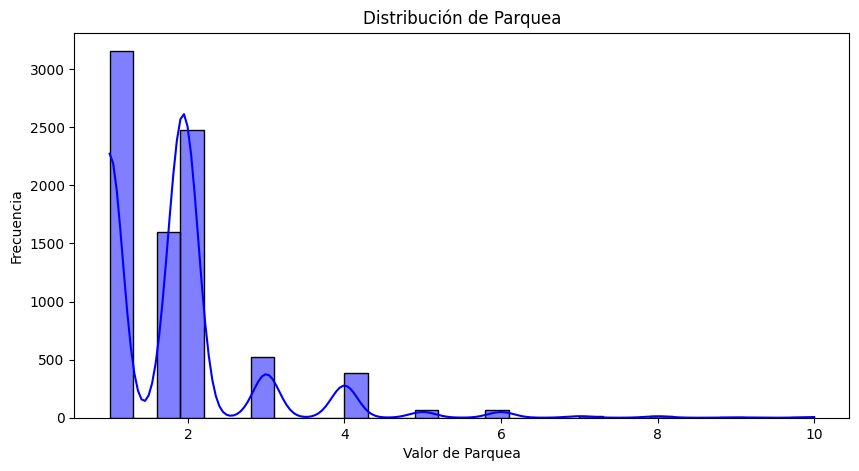

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["parquea"], kde=True, color="blue", bins=30)
plt.title("Distribución de Parquea")
plt.xlabel("Valor de Parquea")
plt.ylabel("Frecuencia")
plt.show()

Para el de piso nos funcionó fue una imputación simple que es la moda, donde nos mantiene una distribución acorde

In [ ]:
moda = df["piso"].mode()
df["piso"].fillna(moda.values[0], inplace=True)

In [ ]:
df.isnull().sum()

id           0
zona         0
piso         0
estrato      0
preciom      0
areaconst    0
parquea      0
banios       0
habitac      0
tipo         0
barrio       0
longitud     0
latitud      0
dtype: int64

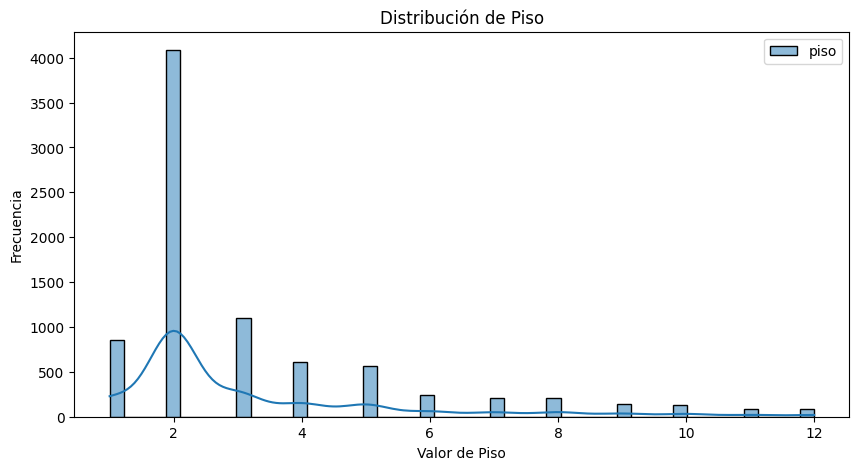

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df[["piso"]], kde=True, color="green", bins=50)
plt.title("Distribución de Piso")
plt.xlabel("Valor de Piso")
plt.ylabel("Frecuencia")
plt.show()

#**Hipótesis**

##*1*

- Hipótesis nula:

H0: El precio medio de las casas en las zonas Oeste y Sur es igual.

- Hipótesis alternativa:

H1: El precio medio de las casas en las zonas Oeste y Sur es diferente

Estadístico de t

Se usa para comparar las medias de dos grupos de datos. Es un método paramétrico, lo que significa que asume que los datos se distribuyen normalmente y que las varianzas de los dos grupos son iguales (homogeneidad).

In [ ]:
df_oeste = df[df['zona'] == 'Zona Oeste']
df_sur = df[df['zona'] == 'Zona Sur']

In [ ]:
precio_medio_oeste = df_oeste['preciom'].mean()
precio_medio_sur = df_sur['preciom'].mean()

In [ ]:
t_stat, p_value = stats.ttest_ind(df_oeste['preciom'], df_sur['preciom'])

<ipython-input-49-292423409480>:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat, p_value = stats.ttest_ind(df_oeste['preciom'], df_sur['preciom'])


In [ ]:
if p_value < 0.05:
    print(f'Rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')
else:
    print(f'No rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')

Rechazamos la hipótesis nula con un nivel de significancia de 5.361410127177567e-112.


##**2**

- Hipótesis nula:

H0: No existe una relación entre el precio de la casa y el tamaño de la casa.

- Hipótesis alternativa:

H1: Existe una relación entre el precio de la casa y el tamaño de la casa.

Estadístico de Pearson

Es utilizado para medir la relación lineal entre dos variables cuantitativas. Es un método no paramétrico, lo que significa que no asume ninguna distribución de los datos.



In [ ]:
p_value = stats.pearsonr(df['preciom'], df['areaconst'])[1]

<ipython-input-51-c61b35d8bb23>:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  p_value = stats.pearsonr(df['preciom'], df['areaconst'])[1]


In [ ]:
if p_value < 0.05:
    print(f'Rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')
else:
    print(f'No rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')

Rechazamos la hipótesis nula con un nivel de significancia de 0.0.


##**3**

- Hipótesis nula:

H0: No existe una relación entre el precio medio de la casa y el tipo.

- Hipótesis alternativa:

H1: Existe una relación entre el precio medio de la casa y el tipo.

ANOVA de una vía

Se utiliza para comparar las medias de tres o más grupos de datos. Es un método paramétrico, lo que significa que asume que los datos se distribuyen normalmente y que las varianzas de los grupos son iguales (homogeneidad).

In [ ]:
media_casa = df[df['tipo'] == 'casa']['preciom'].mean()
media_apartamentos = df[df['tipo'] == 'apartamento']['preciom'].mean()

In [ ]:
f_stat, p_value = stats.f_oneway(df[df['tipo'] == 'casa']['preciom'], df[df['tipo'] == 'apartamento']['preciom'])

<ipython-input-54-e4cfa31312d7>:1: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  f_stat, p_value = stats.f_oneway(df[df['tipo'] == 'casa']['preciom'], df[df['tipo'] == 'apartamento']['preciom'])


In [ ]:
if p_value < 0.05:
    print(f'Rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')
else:
    print(f'No rechazamos la hipótesis nula con un nivel de significancia de {p_value}.')

Rechazamos la hipótesis nula con un nivel de significancia de 8.118570078891453e-125.


#**Preparación para predicción**

El get_dummies nos permitirá hacer una téctina llamada One Hot Encoding es un proceso mediante el cual las variables categóricas se convierten en una forma que podría proporcionarse a los algoritmos de ML para hacer un mejor trabajo en la predicción, volviendolas en binarias, es decir 0 y 1

In [ ]:
data = pd.get_dummies(df, columns=["zona"])
data.head()

id  piso  estrato  preciom  areaconst   parquea  banios  habitac  \
0  1.0     2        6    880.0      237.0  2.000000       5        4   
1  2.0     2        4   1200.0      800.0  3.000000       6        7   
2  3.0     3        5    250.0       86.0  1.835194       2        3   
3  4.0     2        6   1280.0      346.0  4.000000       6        5   
4  5.0     2        6   1300.0      600.0  4.000000       7        5   

          tipo         barrio  longitud  latitud  zona_Zona Centro  \
0         casa          PANCE -76.46300  3.43000                 0   
1         casa     MIRAFLORES -76.46400  3.42800                 0   
2  apartamento    MULTICENTRO -76.46400  3.42900                 0   
3  apartamento  CIUDAD JARDIN -76.46400  3.43300                 0   
4         casa          PANCE -76.46438  3.43463                 0   

   zona_Zona Norte  zona_Zona Oeste  zona_Zona Oriente  zona_Zona Sur  
0                0                0                  0              1  
1                0                1                  0              0  
2                0                0                  0              1  
3                0                0                  0              1  
4                0                0                  0              1

Luego aplicamos a barrio una técnica llamada lavel encoding que es para cuendo tenemos muchos datos diferentes, entonces ya one hot no sirve, está da como un id a cada registro categórico

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["barrio"] = le.fit_transform(data["barrio"])

data.head()

id  piso  estrato  preciom  areaconst   parquea  banios  habitac  \
0  1.0     2        6    880.0      237.0  2.000000       5        4   
1  2.0     2        4   1200.0      800.0  3.000000       6        7   
2  3.0     3        5    250.0       86.0  1.835194       2        3   
3  4.0     2        6   1280.0      346.0  4.000000       6        5   
4  5.0     2        6   1300.0      600.0  4.000000       7        5   

          tipo  barrio  longitud  latitud  zona_Zona Centro  zona_Zona Norte  \
0         casa     225 -76.46300  3.43000                 0                0   
1         casa     206 -76.46400  3.42800                 0                0   
2  apartamento     209 -76.46400  3.42900                 0                0   
3  apartamento      88 -76.46400  3.43300                 0                0   
4         casa     225 -76.46438  3.43463                 0                0   

   zona_Zona Oeste  zona_Zona Oriente  zona_Zona Sur  
0                0                  0              1  
1                1                  0              0  
2                0                  0              1  
3                0                  0              1  
4                0                  0              1

##Generamos las variables independientes (explicatorias) (X) y la variable dependiente (respuesta) (y)

In [ ]:
X = data.drop(['tipo','id'], axis=1)
y = data['tipo']

##**Normalización**

In [ ]:
col_names = list(X.columns)
s_scaler = StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)
X_df.describe()

piso       estrato       preciom     areaconst       parquea  \
count  8.319000e+03  8.319000e+03  8.319000e+03  8.319000e+03  8.319000e+03   
mean  -6.085608e-18 -1.712511e-16 -2.391537e-17  1.908959e-16  2.075512e-16   
std    1.000060e+00  1.000060e+00  1.000060e+00  1.000060e+00  1.000060e+00   
min   -9.555154e-01 -1.587323e+00 -1.143800e+00 -1.013846e+00 -8.263241e-01   
25%   -5.231557e-01 -6.156571e-01 -6.508672e-01 -6.640872e-01 -8.263241e-01   
50%   -5.231557e-01  3.560089e-01 -3.161598e-01 -3.632944e-01  2.196864e-16   
75%    3.415636e-01  3.560089e-01  3.228270e-01  3.781950e-01  1.630554e-01   
max    3.800441e+00  1.327675e+00  4.762264e+00  1.098289e+01  8.078091e+00   

             banios       habitac        barrio      longitud       latitud  \
count  8.319000e+03  8.319000e+03  8.319000e+03  8.319000e+03  8.319000e+03   
mean   1.015336e-16 -9.267206e-17  1.306804e-16 -8.656373e-13  1.300484e-14   
std    1.000060e+00  1.000060e+00  1.000060e+00  1.000060e+00  1.000060e+00   
min   -2.178600e+00 -2.470358e+00 -1.860936e+00 -3.480104e+00 -1.985280e+00   
25%   -7.781616e-01 -4.147875e-01 -8.445768e-01 -7.457600e-01 -8.642764e-01   
50%   -7.794241e-02 -4.147875e-01 -4.321645e-02 -8.013653e-02 -3.856394e-02   
75%    6.222767e-01  2.704026e-01  9.731431e-01  5.584711e-01  8.057948e-01   
max    4.823592e+00  4.381543e+00  1.784276e+00  3.771053e+00  1.877661e+00   

       zona_Zona Centro  zona_Zona Norte  zona_Zona Oeste  zona_Zona Oriente  \
count      8.319000e+03     8.319000e+03     8.319000e+03       8.319000e+03   
mean      -6.683492e-17     6.064255e-17    -1.708241e-17      -2.135301e-17   
std        1.000060e+00     1.000060e+00     1.000060e+00       1.000060e+00   
min       -1.230089e-01    -5.477654e-01    -4.101644e-01      -2.098838e-01   
25%       -1.230089e-01    -5.477654e-01    -4.101644e-01      -2.098838e-01   
50%       -1.230089e-01    -5.477654e-01    -4.101644e-01      -2.098838e-01   
75%       -1.230089e-01    -5.477654e-01    -4.101644e-01      -2.098838e-01   
max        8.129496e+00     1.825599e+00     2.438047e+00       4.764541e+00   

       zona_Zona Sur  
count   8.319000e+03  
mean    1.469087e-16  
std     1.000060e+00  
min    -1.146881e+00  
25%    -1.146881e+00  
50%     8.719303e-01  
75%     8.719303e-01  
max     8.719303e-01

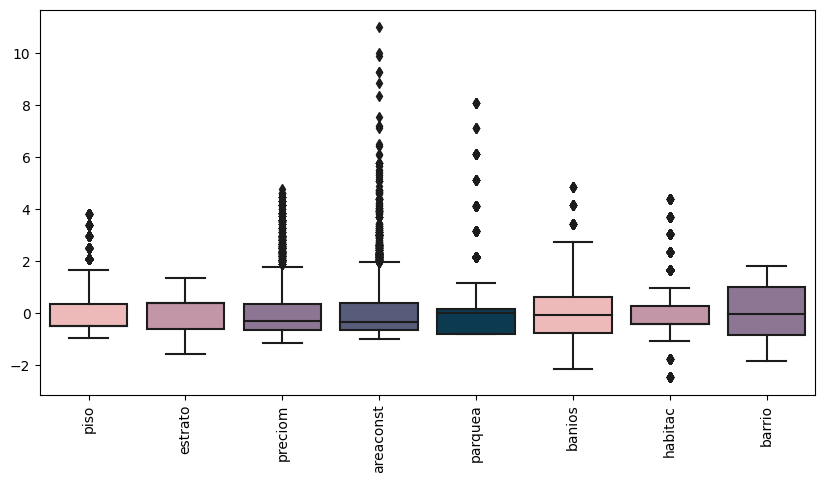

In [ ]:
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
plt.figure(figsize=(10,5))
sns.boxplot(data = X_df[['piso','estrato','preciom','areaconst','parquea','banios','habitac','barrio']],palette = shades)
plt.xticks(rotation=90)
plt.show()

Miramos los ejemplos que tenemos para las variables a predecir que en este caso es apartemento y casa

In [ ]:
y.value_counts()

apartamento    5099
casa           3220
Name: tipo, dtype: int64

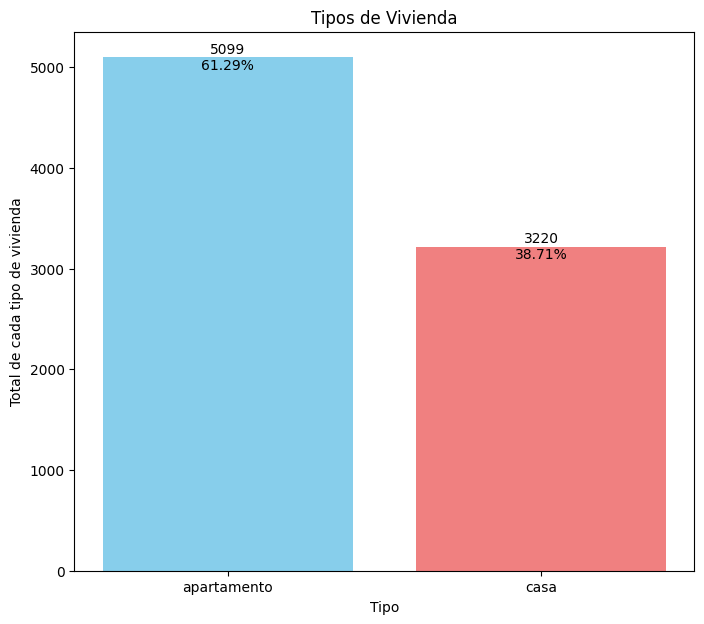

In [ ]:
# Cantidad de cada tipo
cantidad = df['tipo'].value_counts()
total = cantidad.sum()

# Porcentajes
porc = (cantidad / total) * 100

colors = ['skyblue', 'lightcoral']
plt.figure(figsize=(8, 7))

# gráfico de barras
plt.bar(cantidad.index, cantidad, color=colors)
plt.xlabel('Tipo')
plt.ylabel('Total de cada tipo de vivienda')
plt.title('Tipos de Vivienda')
plt.xticks(rotation=0)

# Etiquetas
for i, count in enumerate(cantidad):
    plt.text(i, count, f'{count}\n{porc[i]:.2f}%', ha='center', va='center')

plt.show()

##División conjunto de datos para entrenamiento y prueba

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.3,random_state=42)

##Se aplica el modelo de regresión logística

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

##Se hace la predicción y se evalúa el modelo

Podemos ver que tenemos una buena exactitud y precisión del 90%, es decir que de cada 100 registros puede predecir 90

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 apartamento       0.90      0.94      0.92      1543
        casa       0.90      0.84      0.87       953

    accuracy                           0.90      2496
   macro avg       0.90      0.89      0.90      2496
weighted avg       0.90      0.90      0.90      2496



##Matriz de confusión

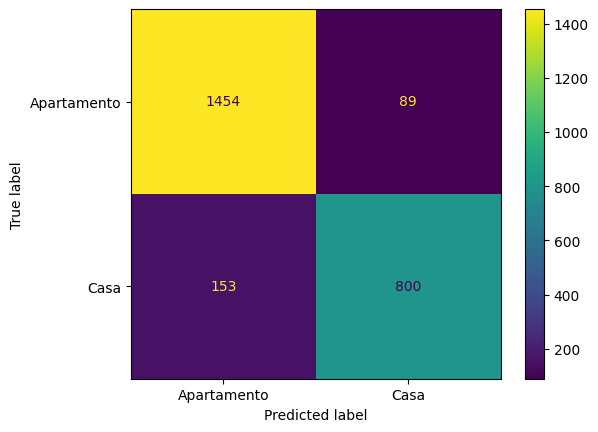

In [ ]:
labels = ["Apartamento", "Casa"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

##Validación cruzada

Aplicamos validación cruzada para asegurarnos de que la predicción obtenida no sea por temás de azar. Y nos damos cuenta de que no es así

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.89365352 0.88336192 0.89365352 0.88831615 0.89003436 0.9209622
 0.895189   0.90206186 0.91752577 0.88831615]


##Curva ROC

Está curva nos permite ver gráficamente el área bajo de la curva que generan los verdaderos positivos vs los falsos positivos, permitiendome ver el rendimiento de mi modelo pero de manera gráfica

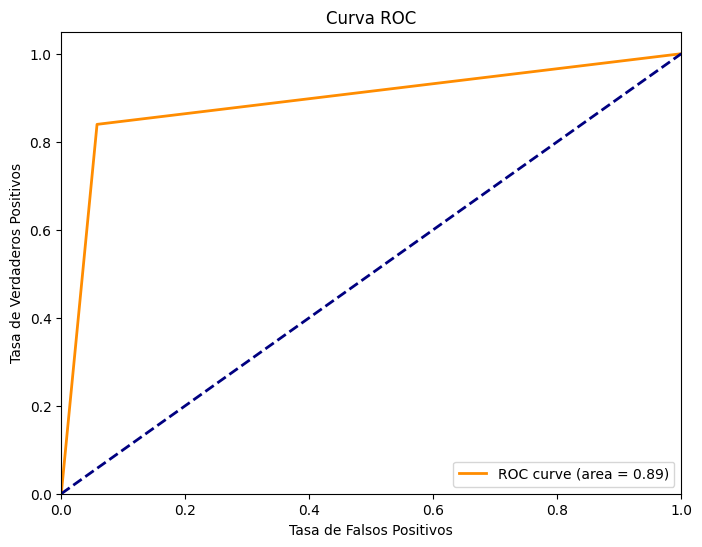

In [ ]:
y_test_binary = np.where(y_test == 'casa', 1, 0)
y_pred_binary = np.where(y_pred == 'casa', 1, 0)

from sklearn.metrics import roc_auc_score,roc_curve
# Calcular la puntuación ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

##Aplicamos Técnicas de over sampling y under sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X1_resampled, y1_resampled = oversampler.fit_resample(X,y)

In [ ]:
y1_resampled.value_counts()

casa           5099
apartamento    5099
Name: tipo, dtype: int64

In [ ]:
model = LogisticRegression()
model.fit(X1_resampled, y1_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y2_pred = model.predict(X_test)
y2_pred = pd.DataFrame(y_pred)

Cómo conclusión dieron las mismas métricas, porque las muestras que teniamos previamente estaban balanceadas.

In [ ]:
print(classification_report(y_test,y2_pred))

              precision    recall  f1-score   support

 apartamento       0.90      0.94      0.92      1543
        casa       0.90      0.84      0.87       953

    accuracy                           0.90      2496
   macro avg       0.90      0.89      0.90      2496
weighted avg       0.90      0.90      0.90      2496



#**MAPA**

Eliminanmos las columnas que NO vamos a utilizar para la creacion del mapa de viviendas en Cali.

In [ ]:
mapa_vivienda = df.drop(['id','piso','estrato','zona','parquea','banios','habitac'], axis=1)
mapa_vivienda.head()

preciom  areaconst         tipo         barrio  longitud  latitud
0    880.0      237.0         casa          PANCE -76.46300  3.43000
1   1200.0      800.0         casa     MIRAFLORES -76.46400  3.42800
2    250.0       86.0  apartamento    MULTICENTRO -76.46400  3.42900
3   1280.0      346.0  apartamento  CIUDAD JARDIN -76.46400  3.43300
4   1300.0      600.0         casa          PANCE -76.46438  3.43463

Casteamos las variables para una visualización agradable a la vista.  
En este caso el precio y el área construida está tipo 'float', lo vamos a cambiar a tipo 'int'

In [ ]:
mapa_vivienda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   preciom    8319 non-null   float64
 1   areaconst  8319 non-null   float64
 2   tipo       8319 non-null   object 
 3   barrio     8319 non-null   object 
 4   longitud   8319 non-null   float64
 5   latitud    8319 non-null   float64
dtypes: float64(4), object(2)
memory usage: 390.1+ KB


In [ ]:
mapa_vivienda['preciom'] = mapa_vivienda['preciom'].astype(int)
mapa_vivienda['areaconst'] = mapa_vivienda['areaconst'].astype(int)
mapa_vivienda.head()

preciom  areaconst         tipo         barrio  longitud  latitud
0      880        237         casa          PANCE -76.46300  3.43000
1     1200        800         casa     MIRAFLORES -76.46400  3.42800
2      250         86  apartamento    MULTICENTRO -76.46400  3.42900
3     1280        346  apartamento  CIUDAD JARDIN -76.46400  3.43300
4     1300        600         casa          PANCE -76.46438  3.43463

In [ ]:
mapa_vivienda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   preciom    8319 non-null   float64
 1   areaconst  8319 non-null   float64
 2   tipo       8319 non-null   object 
 3   barrio     8319 non-null   object 
 4   longitud   8319 non-null   float64
 5   latitud    8319 non-null   float64
dtypes: float64(4), object(2)
memory usage: 390.1+ KB


In [ ]:
pip install folium

In [ ]:
import folium
from folium import Map, Marker, Popup, CustomIcon

Seleccionamos una muestra de 200 datos para poder mostrar una visualización agradable a la vista y también porque si usamos todos los datos, la gráfica no va a cargar bien el mapa debido a la gran cantidad de puntos que tenemos en el dataset, todos ubicados en la ciudad Santiago de Cali.

In [ ]:
mapa_folium = mapa_vivienda.sample(200)
mapa_folium

preciom  areaconst         tipo          barrio  longitud  latitud
6137    460.0      318.0         casa         LIMONAR -76.54099  3.43191
2938    325.0       84.0  apartamento      VALLE LILI -76.52300  3.36478
7166    950.0      326.0  apartamento      SANTA RITA -76.54800  3.44600
6822    480.0      130.0  apartamento  SANTA TERESITA -76.54500  3.43400
3387    480.0      260.0  apartamento    PRADOS NORTE -76.52600  3.40400
...       ...        ...          ...             ...       ...      ...
3003    265.0       78.0  apartamento      VALLE LILI -76.52328  3.37434
228     350.0      137.0  apartamento     CHIMINANGOS -76.48995  3.49770
5584    175.0       66.0  apartamento   CIUDAD JARDIN -76.53738  3.38242
3425    210.0       68.0  apartamento       VERSALLES -76.52616  3.46978
7221    320.0      200.0         casa    ALFEREZ REAL -76.54814  3.38731

[200 rows x 6 columns]

In [ ]:
# Mapa
m = folium.Map(location=[3.4, -76.5], zoom_start=8)

# Recorre cada fila
for index, fila in mapa_folium.iterrows():

    # Marcador
    folium.Marker(
        location=[fila['latitud'], fila['longitud']],
        popup=folium.Popup(f"<b>Tipo:</b> {fila['tipo']}<br><b>Barrio:</b> {fila['barrio']}<br><b>Precio:</b> {fila['preciom']} millones<br><b>Área:</b> {fila['areaconst']} m2", max_width=300),
        icon=folium.Icon(color='red', icon='star')
    ).add_to(m)

m

In [ ]:
# from google.colab import files

# Mapa
# m = folium.Map(location=[3.4, -76.5], zoom_start=8)

# Iconos
# icon_casa = '/content/drive/MyDrive/Mineria/iconos/casa.png'
# icon_apto = '/content/drive/MyDrive/Mineria/iconos/apto.png'

# Recorre cada fila
# for index, mapa_folium in mapa_folium.iterrows():

    # Condicion Icono
    # if mapa_folium['tipo'] == 'casa':
    #     icon = folium.CustomIcon(icon_image=icon_casa, icon_size=(32, 32))
    # elif mapa_folium['tipo'] == 'apartamento':
    #     icon = folium.CustomIcon(icon_image=icon_apto, icon_size=(32, 32))
    # else:
    #     icon = folium.Icon(color='red', icon='star')

    # Marcador
    # folium.Marker(
    #     location=[mapa_folium['latitud'], mapa_folium['longitud']],
    #     popup=folium.Popup(f"<b>Tipo:</b> {mapa_folium['tipo']}<br><b>Barrio:</b> {mapa_folium['barrio']}<br><b>Precio:</b> {mapa_folium['preciom']} millones<br><b>Área:</b> {mapa_folium['areaconst']} m2", max_width=300),
    #     icon=icon
    # ).add_to(m)

# m.save('mapa.html')
# files.download('mapa.html')